# EXERCÍCIO 3
PROPOSTO PELO PROF JULIANO DA PUCRS NA AULA 4 DA DISCIPLINA DE PRÉ-PROCESSAMENTO DE DADOS NO CURSO DE PÓS GRADUAÇÃO EM CIÊNCIA DE DADOS E INTELIGÊNCIA ARTIFICIAL DA PUCRS - TURMA 2-2021

Neste exercício, são utilizados arquivos csv contendo informações sobre pedidos de café da manhã em uma lanchonete, sobre jogadores de NBA e sobre suas métricas, e sobre avaliações de Ramen para exercitar algumas técnicas de pré-processamento de dados, tais como detecção de outliers extremos e sua correção, bem como substituição de valores ausentes e codificação "one-hot".

# Introdução
imports de bibliotecas python e montando g-drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#   Por serem arquivos pequenos e que estavam disponibilizados em um dropbox  
# de terceiros (portanto, cuja duração do link de download seria desconhecida), 
# os arquivos foram salvos no google drive em que está salvo este colab e de lá 
# serão importados.

from google.colab import drive
drive.mount('/content/gdrive')
folder_gdrive = '/content/gdrive/My Drive/Data Science/Python/2021-22 PUCRS Pós/Disciplina 5 Pré-processamento de Dados/Prof Juliano PUCRS/Aula 4/Datasets/'

Mounted at /content/gdrive


# EXERCICIO 3.1 - Café da manhã
Objetivo do exercício: buscar itens que sejam frequentemente comprados juntos

In [5]:
# Importando o arquivo .csv em um pandas DataFrame e visualizando o cabeçalho do df resultante
breakfast_df  = pd.read_csv(folder_gdrive + 'CAFE_DA_MANHA.csv')
breakfast_df.head(5)

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


Estrutura do CSV: 
*   Date: data da compra;
*   Time: hora da compra;
*   Transaction: identificador da compra (vários itens podem compor uma compra); 
*   Item: item que foi comprado (está dentro de uma transaction). 


In [ ]:
# Verificando se alguma label do df possui valores NaN
breakfast_df.isnull().any() # Nenhum - ok, não necessita tratamento de valores ausentes

Date           False
Time           False
Transaction    False
Item           False
dtype: bool

In [8]:
# Acrescentando label - coluna com quantidade = 1 - para uso posterior (facilitará o pivoteamento)
breakfast_df['Qtd'] = 1
breakfast_df.head(5)

,Date,Time,Transaction,Item,Qtd
0,2016-10-30,09:58:11,1,Bread,1
1,2016-10-30,10:05:34,2,Scandinavian,1
2,2016-10-30,10:05:34,2,Scandinavian,1
3,2016-10-30,10:07:57,3,Hot chocolate,1
4,2016-10-30,10:07:57,3,Jam,1


In [9]:
# Para facilitar análise do que constitui cada pedido, cria-se uma tabela pivot dos itens de cada transação, 
                                                      # substituindo valores ausentes por 0
breakfast_pivot_df = breakfast_df.pivot_table(values = 'Qtd', index = 'Transaction', columns = 'Item', fill_value=0)
breakfast_pivot_df.head(10)

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,Bowl Nic Pitt,Bread,Bread Pudding,Brioche and salami,Brownie,Cake,Caramel bites,Cherry me Dried fruit,Chicken Stew,Chicken sand,Chimichurri Oil,Chocolates,Christmas common,Coffee,Coffee granules,Coke,Cookies,Crepes,Crisps,Drinking chocolate spoons,Duck egg,Dulce de Leche,Eggs,Ella's Kitchen Pouches,Empanadas,Extra Salami or Feta,Fairy Doors,Farm House,Focaccia,Frittata,...,Medialuna,Mighty Protein,Mineral water,Mortimer,Muesli,Muffin,My-5 Fruit Shoot,NONE,Nomad bag,Olum & polenta,Panatone,Pastry,Pick and Mix Bowls,Pintxos,Polenta,Postcard,Raspberry shortbread sandwich,Raw bars,Salad,Sandwich,Scandinavian,Scone,Siblings,Smoothies,Soup,Spanish Brunch,Spread,Tacos/Fajita,Tartine,Tea,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
# Criando uma matriz de correlação dos itens a partir da lista de transações usando índice de Pearson
corrBreakfast = breakfast_pivot_df.corr()
corrBreakfast

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,Bowl Nic Pitt,Bread,Bread Pudding,Brioche and salami,Brownie,Cake,Caramel bites,Cherry me Dried fruit,Chicken Stew,Chicken sand,Chimichurri Oil,Chocolates,Christmas common,Coffee,Coffee granules,Coke,Cookies,Crepes,Crisps,Drinking chocolate spoons,Duck egg,Dulce de Leche,Eggs,Ella's Kitchen Pouches,Empanadas,Extra Salami or Feta,Fairy Doors,Farm House,Focaccia,Frittata,...,Medialuna,Mighty Protein,Mineral water,Mortimer,Muesli,Muffin,My-5 Fruit Shoot,NONE,Nomad bag,Olum & polenta,Panatone,Pastry,Pick and Mix Bowls,Pintxos,Polenta,Postcard,Raspberry shortbread sandwich,Raw bars,Salad,Sandwich,Scandinavian,Scone,Siblings,Smoothies,Soup,Spanish Brunch,Spread,Tacos/Fajita,Tartine,Tea,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Item,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Adjustment,1.000000,-0.000690,-0.001982,-0.000278,-0.000648,-0.000105,-0.001304,-0.000729,-0.000235,-0.000257,-0.000148,-0.007107,-0.000210,-0.000182,-0.002085,-0.003474,-0.000182,-0.000182,-0.001171,-0.000105,-0.000148,-0.000315,-0.000348,-0.009745,-0.000278,-0.001437,-0.002448,-0.000257,-0.000393,-0.000297,-0.000364,-0.000379,-0.000556,-0.000433,-0.000278,-0.000648,-0.000148,-0.002062,-0.000773,-0.000948,...,-0.002619,-0.000348,-0.001223,-0.000235,-0.000297,-0.002041,-0.000446,-0.003000,-0.000297,-0.000105,-0.000235,-0.003132,-0.000364,-0.000257,-0.000105,-0.000332,-0.000182,-0.000105,-0.001049,-0.002839,-0.001766,-0.001931,-0.000148,-0.000924,-0.001928,-0.001389,-0.000148,-0.000348,-0.000713,-0.004161,-0.000105,-0.000802,-0.001278,-0.001903,-0.001469,-0.000481,-0.000379,-0.000420,-0.000759,-0.000278
Afternoon with the baker,-0.000690,1.000000,-0.013027,0.113756,-0.004259,-0.000690,-0.008570,-0.004790,-0.001542,-0.001690,-0.000975,-0.036678,-0.001379,-0.001195,0.002324,-0.017682,-0.001195,-0.001195,-0.007698,-0.000690,-0.000975,-0.002070,-0.002288,-0.051505,-0.001825,-0.009445,-0.009165,-0.001690,-0.002582,-0.001951,0.041760,-0.002488,-0.003654,-0.002846,-0.001825,0.020585,-0.000975,-0.013548,-0.005082,-0.006233,...,-0.017215,-0.002288,-0.008039,-0.001542,-0.001951,-0.013415,-0.002928,-0.008109,-0.001951,-0.000690,-0.001542,-0.020586,-0.002390,-0.001690,-0.000690,-0.002182,-0.001195,-0.000690,-0.006897,-0.018660,-0.002251,-0.012689,-0.000975,0.011413,-0.004055,0.014395,-0.000975,-0.002288,-0.004688,-0.013877,-0.000690,0.014863,-0.008397,-0.012507,0.001491,-0.003163,-0.002488,-0.002761,-0.004986,-0.001825
Alfajores,-0.001982,-0.013027,1.000000,-0.005246,0.014537,-0.001982,-0.002183,0.002126,-0.004433,-0.004857,-0.002803,-0.016550,-0.003965,0.028277,0.038347,0.006512,-0.003434,-0.003434,-0.007174,-0.001982,-0.002803,0.012365,-0.006578,0.025426,-0.005246,-0.002621,0.010978,0.039997,0.007266,-0.005609,-0.006870,0.038573,-0.000110,0.005151,0.015518,-0.012243,-0.002803,-0.027310,0.007877,-0.005659,...,0.020824,-0.006578,0.034226,-0.004433,-0.005609,0.008401,0.017495,-0.019139,-0.005609,-0.001982,-0.004433,0.003187,0.008993,-0.004857,-0.001982,-0.006271,-0.003434,-0.001982,-0.003180,0.000999,0.013692,0.003701,-0.002803,0.001388,-0.017846,0.016024,-0.002803,0.009990,-0.005359,0.024642,-0.001982,-0.007908,0.012506,-0.020289,0.016296,-0.009093,-0.007151,-0.007935,0.000941,0.015518
Argentina Night,-0.000278,0.113756,-0.005246,1.000000,-0.001715,-0.000278,-0.003451,-0.001929,-0.000621,-0.000680,-0.000393,-0.010540,-0.000556,-0.000481,-0.005517,-0.009194,-0.000481,-0.000481,-0.003100,-0.000278,-0.000393,-0.000833,-0.000922,-0.025792,-0.000735,-0.003804,-0.006479,-0.000680,-0.001040,-0.000786,-0.000963,-0.001002,-0.001472,-0.001146,-0.000735,-0.001715,-0.000393,-0.005456,-0.002046,-0.002510,...,-0.006933,-0.000922,-0.003237,-0.000621,-0.000786,-0.005402,-0.001179,0.006417,-0.000786,-0.000278,-0.000621,-0.008290,-0.000963,-0.000680,-0.000278,-0.000879,-0.

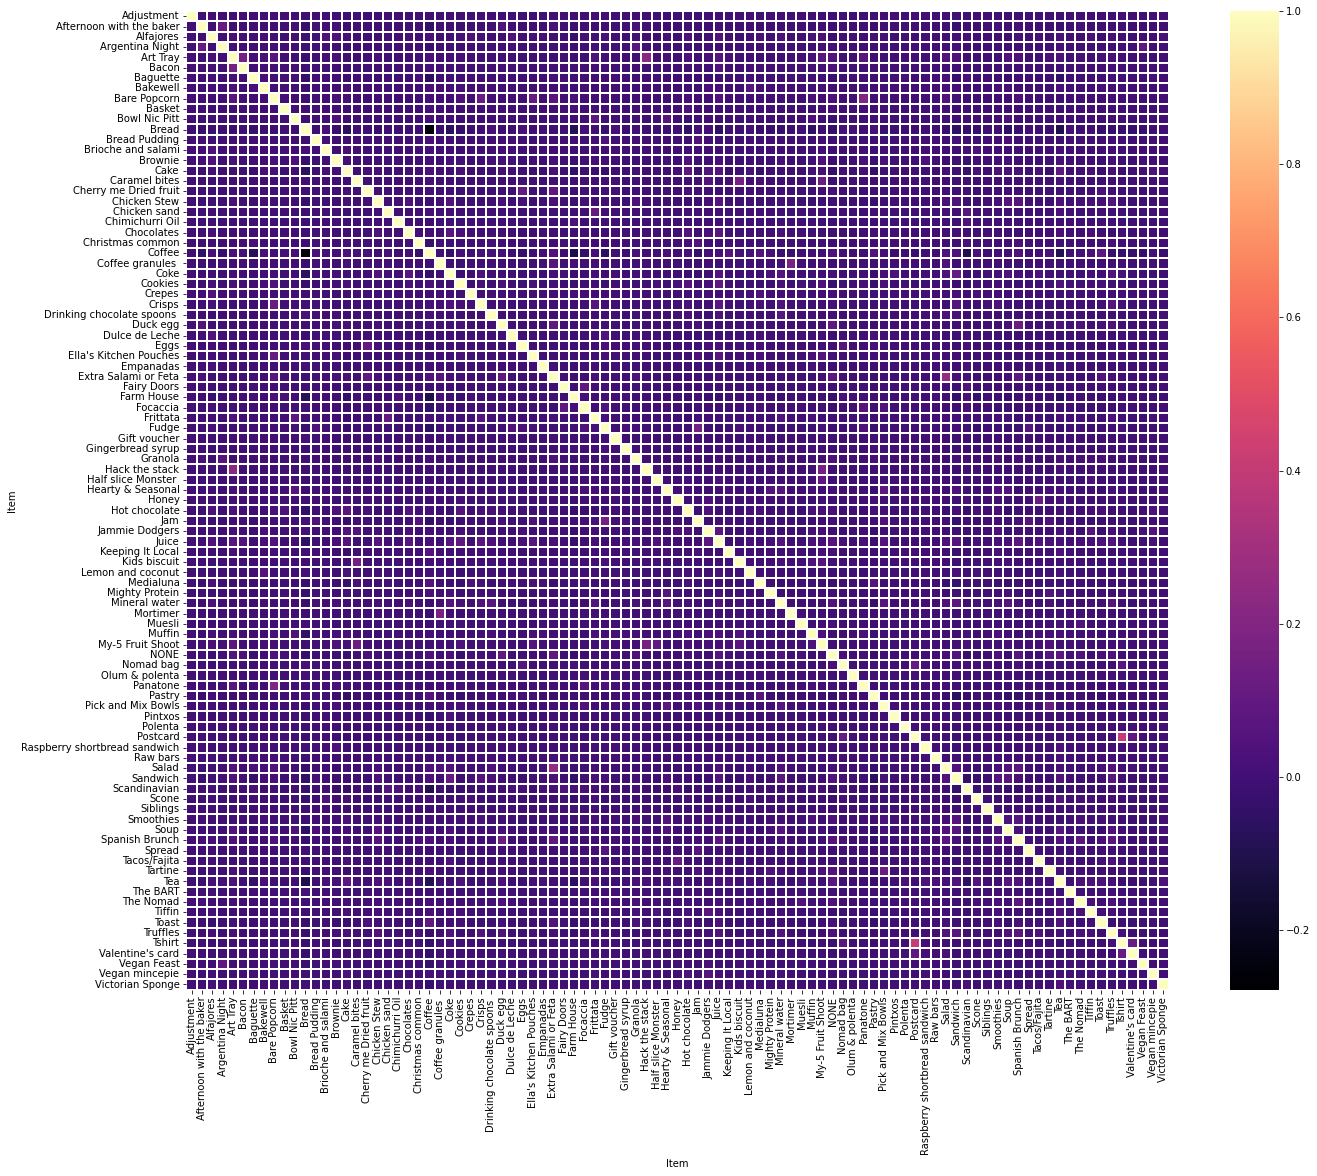

In [11]:
# Plotando um gráfico de calor da matriz de correlação
plt.figure(figsize=[22,18])
sns.heatmap(corrBreakfast, cmap='magma', linecolor='w', linewidths=1)

A única correlação que se destaca é Tshirt com Postcard, curiosamente não são itens de café da manhã.
Também há uma pequena correlação de Salad com Extra Salami or Feta, isto sim relacionado a café.

# EXERCICIO 3.2 - NBA
Fonte dos dados: https://kaggle.com/drgilermo/nba-players-stats 


 

*   JOGADORES_NBA: contém informações sobre os jogadores da NBA. Lá temos informações como peso, altura, ano e local de nascimento de cada atleta.
*    METRICAS_NBA: contém o histórico de estatísticas dos jogadores/times em que jogaram. 



## Item 1: Importando arquivos

In [12]:
# Importando o arquivo .xlsx dos dados de jogadores em um pandas DataFrame e visualizando o cabeçalho do df resultante
nba_players_df  = pd.read_excel(folder_gdrive + 'JOGADORES_NBA.xlsx', index_col=0)
nba_players_df.head(5)

,Player,height,weight,collage,born,birth_city,birth_state
0,Curly Armstrong,180.0,77.0,Indiana University,1918.0,NaN,NaN
1,Cliff Barker,188.0,83.0,University of Kentucky,1921.0,Yorktown,Indiana
2,Leo Barnhorst,193.0,86.0,University of Notre Dame,1924.0,NaN,NaN
3,Ed Bartels,196.0,88.0,North Carolina State University,1925.0,NaN,NaN
4,Ralph Beard,178.0,79.0,University of Kentucky,1927.0,Hardinsburg,Kentucky


In [13]:
# Importando o arquivo .xlsx das métricas dos jogadores em um pandas DataFrame e visualizando o cabeçalho do df resultante
nba_metrics_df  = pd.read_excel(folder_gdrive + 'METRICAS_NBA.xlsx', index_col=0)
nba_metrics_df.head(5)

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1950,Curly Armstrong,G-F,31.0,FTW,63,NaN,NaN,NaN,0.368,NaN,0.467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.1,3.6,3.5,NaN,NaN,NaN,NaN,NaN,NaN,144,516,0.279,NaN,NaN,NaN,144,516,0.279,0.279,170,241,0.705,NaN,NaN,NaN,176,NaN,NaN,NaN,217,458
1,1950,Cliff Barker,SG,29.0,INO,49,NaN,NaN,NaN,0.435,NaN,0.387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,0.6,2.2,NaN,NaN,NaN,NaN,NaN,NaN,102,274,0.372,NaN,NaN,NaN,102,274,0.372,0.372,75,106,0.708,NaN,NaN,NaN,109,NaN,NaN,NaN,99,279
2,1950,Leo Barnhorst,SF,25.0,CHS,67,NaN,NaN,NaN,0.394,NaN,0.259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,2.8,3.6,NaN,NaN,NaN,NaN,NaN,NaN,174,499,0.349,NaN,NaN,NaN,174,499,0.349,0.349,90,129,0.698,NaN,NaN,NaN,140,NaN,NaN,NaN,192,438
3,1950,Ed Bartels,F,24.0,TOT,15,NaN,NaN,NaN,0.312,NaN,0.395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.1,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,22,86,0.256,NaN,NaN,NaN,22,86,0.256,0.256,19,34,0.559,NaN,NaN,NaN,20,NaN,NaN,NaN,29,63
4,1950,Ed Bartels,F,24.0,DNN,13,NaN,NaN,NaN,0.308,NaN,0.378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.1,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,21,82,0.256,NaN,NaN,NaN,21,82,0.256,0.256,17,31,0.548,NaN,NaN,NaN,20,NaN,NaN,NaN,27,59


## Item 2: Junção dos dataframes

In [14]:
nba_df = nba_metrics_df.merge(nba_players_df, on='Player') # Fazendo uma junção à esquerda
nba_df.head(5)

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight,collage,born,birth_city,birth_state
0,1950,Curly Armstrong,G-F,31.0,FTW,63,NaN,NaN,NaN,0.368,NaN,0.467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.1,3.6,3.5,NaN,NaN,NaN,NaN,NaN,NaN,144,516,0.279,NaN,NaN,NaN,144,516,0.279,0.279,170,241,0.705,NaN,NaN,NaN,176,NaN,NaN,NaN,217,458,180.0,77.0,Indiana University,1918.0,NaN,NaN
1,1951,Curly Armstrong,G-F,32.0,FTW,38,NaN,NaN,NaN,0.372,NaN,0.388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.3,0.9,0.6,NaN,NaN,NaN,NaN,NaN,NaN,72,232,0.310,NaN,NaN,NaN,72,232,0.310,0.310,58,90,0.644,NaN,NaN,89.0,77,NaN,NaN,NaN,97,202,180.0,77.0,Indiana University,1918.0,NaN,NaN
2,1950,Cliff Barker,SG,29.0,INO,49,NaN,NaN,NaN,0.435,NaN,0.387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,0.6,2.2,NaN,NaN,NaN,NaN,NaN,NaN,102,274,0.372,NaN,NaN,NaN,102,274,0.372,0.372,75,106,0.708,NaN,NaN,NaN,109,NaN,NaN,NaN,99,279,188.0,83.0,University of Kentucky,1921.0,Yorktown,Indiana
3,1951,Cliff Barker,SG,30.0,INO,56,NaN,NaN,NaN,0.322,NaN,0.381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.9,0.7,-0.2,NaN,NaN,NaN,NaN,NaN,NaN,51,202,0.252,NaN,NaN,NaN,51,202,0.252,0.252,50,77,0.649,NaN,NaN,100.0,115,NaN,NaN,NaN,98,152,188.0,83.0,University of Kentucky,1921.0,Yorktown,Indiana
4,1952,Cliff Barker,SG,31.0,INO,44,NaN,494.0,10.8,0.343,NaN,0.317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.7,0.8,0.1,0.008,NaN,NaN,NaN,NaN,NaN,48,161,0.298,NaN,NaN,NaN,48,161,0.298,0.298,30,51,0.588,NaN,NaN,81.0,70,NaN,NaN,NaN,56,126,188.0,83.0,University of Kentucky,1921.0,Yorktown,Indiana


### Avaliação de junção funcionou como esperado

In [15]:
nba_players_df.shape

(3922, 7)

In [16]:
nba_metrics_df.shape

(24624, 52)

In [17]:
nba_df.shape

(24624, 58)

## Item 3: tratamento de valores extremos nos campos height, weight, TS% e FTr

### Corrigindo Height
Obs: Height está em cm

In [18]:
nba_df['height'].describe() 
# A média de 5.7 kilometros é obviamente irreal, bem como jogadores com apenas 1 cm. 
# Além disso, há pelo menos um outlier gigantesco que precisaremos remover
# Há valores extremos que devem ser corrigidos. Serão substituídos pela média dos valores não-extremos.

count    2.459400e+04
mean     5.738784e+05
std      3.399986e+07
min      1.000000e+00
25%      1.930000e+02
50%      2.010000e+02
75%      2.060000e+02
max      2.015560e+09
Name: height, dtype: float64

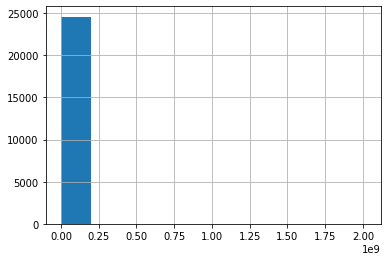

In [19]:
nba_df['height'].hist() # até o histograma ficou distorcidissimo

In [20]:
# Height_high_quantile_percent
h_high_qtl_pct = 0.9987  # Buscando como fator de corte 231 cm, encontrei que apenas 0,13% dos mais altos devem ser corrigidos

# Height_high_quantile
h_high_qtl = nba_df['height'].quantile(h_high_qtl_pct) 
h_high_qtl
# O jogador da NBA  mais alto da historia possuia 231 cm, 
# então valores acima deste devem ser considerados incorretos

231.0

In [21]:
# Height_low_quantile_percent
h_low_qtl_pct = 0.001  # Buscando como fator de corte 160 cm, encontrei que apenas 0,1% dos mais baixos devem ser corrigidos

# Height_low_quantile
h_low_qtl = nba_df['height'].quantile(h_low_qtl_pct)
h_low_qtl
# O jogador da NBA  mais baixo da historia possuia 160 cm, 
# então valores abaixo deste devem ser considerados incorretos


160.0

In [22]:
# Calculando media das alturas sem os valores extremos
height_avg_outlrmvd = nba_df[(nba_df['height'] > h_low_qtl) & # Utiliza apenas valores acima do valor minimo (160 cm)
                             (nba_df['height'] < h_high_qtl)  # Utiliza apenas valores abaixo do valor máximo (231 cm)
                             ]['height'].mean()
height_avg_outlrmvd  # media de 199 cm faz muito mais sentido

199.41613284915746

In [23]:
# Substituindo estes valores extremos pela media em uma coluna height_NoOutliers
nba_df['height_NO'] = np.where(nba_df['height'] < h_low_qtl, height_avg_outlrmvd, nba_df['height']) # Valores abaixo do minimo substituídos pela média
nba_df['height_NO'] = np.where(nba_df['height'] > h_high_qtl, height_avg_outlrmvd, nba_df['height_NO'])# Valores acima do máximo substituídos pela média

#### Verificando rapidamente o resumo dos dados de altura sem valores extremos

In [24]:
nba_df['height_NO'].describe() # agora sim os resultados fazem sentido, media de 199 cm e demais valores ok

count    24594.000000
mean       199.414890
std          9.363617
min        160.000000
25%        193.000000
50%        201.000000
75%        206.000000
max        231.000000
Name: height_NO, dtype: float64

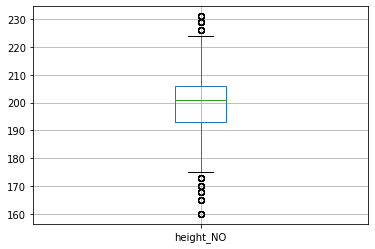

In [25]:
nba_df.boxplot('height_NO')
# OBS: o boxplot apresenta que, na amostra coletada dos jogadores da nba, há 
# casos de outliers, no sentido de terem alturas acima ou abaixo da curva média.
# Porém, esses valores outliers são apenas valores reais com relativamente grande 
# desvio dos valores médios, diferentemente dos valores extremos, filtrados pelo 
# código, que eram dados irreais neste contexto.

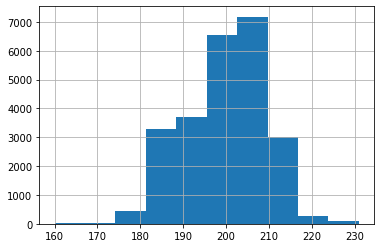

In [26]:
nba_df['height_NO'].hist() # Agora o histograma possui cara de fenômeno físico,
# com uma tendência aos valores mais altos que se encaixa no contexto de basquete

### Corrigindo Weight
Obs.: Weight está em kg

In [27]:
nba_df['weight'].describe() 
# Média de peso de 252 toneladas também é irreal, porém os resultados dos 
# quartis 25% e 75% são realistas. Há valores extremos que devem ser corrigidos. 
# Serão substituídos pela média dos valores não-extremos.

count    2.462100e+04
mean     2.527246e+05
std      1.498073e+07
min      0.000000e+00
25%      8.600000e+01
50%      9.500000e+01
75%      1.040000e+02
max      8.885660e+08
Name: weight, dtype: float64

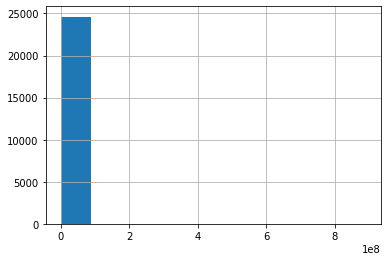

In [28]:
nba_df['weight'].hist() # até o histograma também ficou distorcidissimo

In [29]:
# para buscar os valores extremos:
nba_df['weight'].sort_values().unique()
# a partir da avaliação dos valores individuais de peso  
# dos atletas, identifica-se que os valores extremos são   
# os menores do que 60 e maiores do que 163.

array([0.00000000e+00, 1.00000000e+00, 2.00000000e+00, 6.00000000e+01,
       6.10000000e+01, 6.30000000e+01, 6.80000000e+01, 6.90000000e+01,
       7.00000000e+01, 7.20000000e+01, 7.30000000e+01, 7.40000000e+01,
       7.50000000e+01, 7.60000000e+01, 7.70000000e+01, 7.80000000e+01,
       7.90000000e+01, 8.00000000e+01, 8.10000000e+01, 8.20000000e+01,
       8.30000000e+01, 8.40000000e+01, 8.50000000e+01, 8.60000000e+01,
       8.70000000e+01, 8.80000000e+01, 8.90000000e+01, 9.00000000e+01,
       9.10000000e+01, 9.20000000e+01, 9.30000000e+01, 9.40000000e+01,
       9.50000000e+01, 9.60000000e+01, 9.70000000e+01, 9.80000000e+01,
       9.90000000e+01, 1.00000000e+02, 1.01000000e+02, 1.02000000e+02,
       1.03000000e+02, 1.04000000e+02, 1.05000000e+02, 1.06000000e+02,
       1.07000000e+02, 1.08000000e+02, 1.09000000e+02, 1.10000000e+02,
       1.11000000e+02, 1.12000000e+02, 1.13000000e+02, 1.14000000e+02,
       1.15000000e+02, 1.16000000e+02, 1.17000000e+02, 1.18000000e+02,
      

In [30]:
# De acordo com a análise acima:
w_low_qtl = 60
w_high_qtl = 163

In [31]:
# Calculando media dos pesos sem os valores extremos
weight_avg_outlrmvd = nba_df[(nba_df['weight'] > w_low_qtl) & # Utiliza apenas valores acima do valor minimo (60 kg)
                             (nba_df['weight'] < w_high_qtl)  # Utiliza apenas valores abaixo do valor máximo (163 kg)
                             ]['weight'].mean()
weight_avg_outlrmvd  # media de 95 kg faz muito mais sentido

95.55457875457876

In [32]:
# Substituindo estes valores extremos pela media em uma coluna weight_NoOutliers
nba_df['weight_NO'] = np.where(nba_df['weight'] < w_low_qtl, weight_avg_outlrmvd, nba_df['weight']) # Valores abaixo do minimo substituídos pela média
nba_df['weight_NO'] = np.where(nba_df['weight'] > w_high_qtl, weight_avg_outlrmvd, nba_df['weight_NO'])# Valores acima do máximo substituídos pela média

#### Verificando rapidamente o resumo dos dados do peso sem outliers

In [33]:
nba_df['weight_NO'].describe() # resultados fazem sentido

count    24621.000000
mean        95.537101
std         12.038910
min         60.000000
25%         86.000000
50%         95.000000
75%        104.000000
max        163.000000
Name: weight_NO, dtype: float64

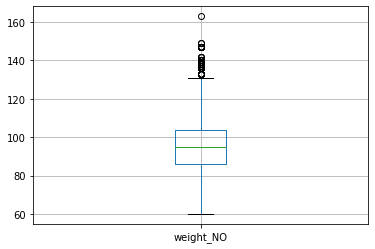

In [34]:
nba_df.boxplot('weight_NO') # interpretações similares a altura

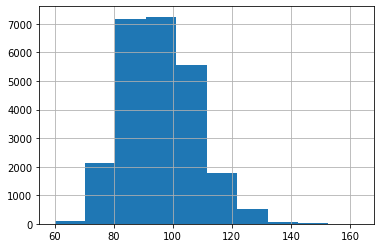

In [35]:
nba_df['weight_NO'].hist()

### Corrigindo TS%
Não conheço essa variável, então não haverá interpretação física como houve com altura e peso. O máximo que posso interpretar é que tratam-se de dados percentuais. Será necessário aplicar apenas métodos analíticos. 

In [36]:
# Iniciando a análise com um resumo estatístico dos dados
nba_df['TS%'].describe()
# Percebe-se que há uma discrepância gigantesca entre a média e a mediana, 
# sugerindo existência de valores extremos. No mínimo, há valores muito altos
# que devem ser corrigidos. Como os valores mínimo e dos 3 quantis são de
# grandeza similar, em um primeiro momento não parece haver valores discre-
# pantes na parcela inferior dos dados.

count    2.453800e+04
mean     1.870578e+03
std      2.928180e+05
min      0.000000e+00
25%      4.580000e-01
50%      5.060000e-01
75%      5.440000e-01
max      4.586880e+07
Name: TS%, dtype: float64

In [37]:
# Inicialmente vamos buscar o valor extremo na parte superior dos dados
nba_df['TS%'].quantile(0.99) # resultado: 0.674, compatível com os quartis 25, 50 e 75%

0.674

In [38]:
nba_df['TS%'].quantile(0.999) # resultado: 1.0, que é 100%. Acredito que seja o
# valor máximo possível

1.0

In [39]:
# Selecionando apenas valores abaixo do valor de 1, do quantil 0,999, para
# realizar breve análise. Percebe-se que o valor extremo segue presente. 
# Isto deve ser consequência de haver valores NaN e estarem no fim da fila 
# do sort_values, trazendo os valores extremos mais para o início.
nba_df['TS%'].sort_values()[0:int(len(nba_df)*0.999)].describe()

count    2.453800e+04
mean     1.870578e+03
std      2.928180e+05
min      0.000000e+00
25%      4.580000e-01
50%      5.060000e-01
75%      5.440000e-01
max      4.586880e+07
Name: TS%, dtype: float64

In [40]:
# Somando a quantidade de valores nulos para subtrair na fórmula anterior
ts_nulos = nba_df['TS%'].isnull().sum() # = 86
nba_df['TS%'].sort_values()[0:int(len(nba_df)*0.999)-ts_nulos].describe()
# Agora sim, está com valores que fazem sentido: percebe-se uma coerência de 
# ordem de grandeza dos valores dos quantis e uma certa proximidade da média
# com a mediana. Realmente parece não haver valores discrepantemente pequenos.

count    24513.000000
mean         0.492528
std          0.093041
min          0.000000
25%          0.458000
50%          0.506000
75%          0.544000
max          1.000000
Name: TS%, dtype: float64

In [41]:
# Calculando media de TS% sem os valores extremos
ts_high_qtl = nba_df['TS%'].quantile(0.999)
ts_avg_outlrmvd = nba_df[nba_df['TS%'] <= ts_high_qtl]['TS%'].mean() 
      # Utiliza apenas valores abaixo de 1.0 no cálculo da média

In [42]:
# Substituindo estes valores extremos pela media em uma coluna TS%_NoOutliers
nba_df['TS%_NO'] = np.where(nba_df['TS%'] > ts_high_qtl, ts_avg_outlrmvd, nba_df['TS%']) # Valores acima do máximo substituídos pela média

#### Verificando rapidamente o resumo dos dados de TS% sem os valores extremos



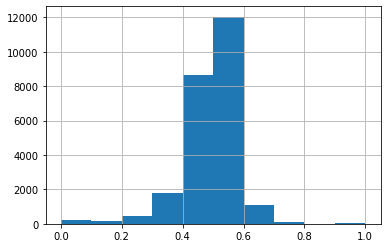

In [43]:
nba_df['TS%_NO'].hist() # Curiosamente a curva é bastante concentrada nos valores médios,
# e com boa aparência de distribuição de algum fenômeno físico

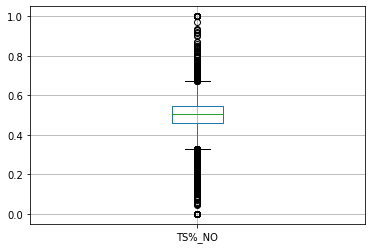

In [44]:
nba_df.boxplot('TS%_NO') # Esta distribuição está muito concentrada nos valores 
# próximos à média, ocasionando com que haja muitos valores considerados outliers

### Corrigindo FTr
Não conheço essa variável, então não haverá interpretação física que houve com altura e peso. Será necessário aplicar apenas métodos analíticos. 

In [45]:
# Iniciando a análise com um resumo estatístico dos dados
nba_df['FTr'].describe()
# Novamente, percebe-se que há uma discrepância gigantesca entre a média e a 
# mediana, sugerindo existência de valores extremos. No mínimo, há valores 
# muito altos que devem ser corrigidos. Como os valores mínimo e dos 3 quantis 
# são de grandeza similar, em um primeiro momento não parece haver valores 
# discrepantes na parcela inferior dos dados.

count    2.452500e+04
mean     2.388542e+04
std      3.739704e+06
min      0.000000e+00
25%      2.080000e-01
50%      2.960000e-01
75%      4.000000e-01
max      5.856548e+08
Name: FTr, dtype: float64

In [46]:
# Novamente, começaremos buscando o valor extremo na parte superior dos dados
nba_df['FTr'].quantile(0.99) # resultado: 1.0, parece que FTr também é uma
# proporção, utilizaremos este valor para o corte

1.0

In [47]:
# Novamente, analisaremos a descrição estatística dos dados removendo o 1% dos
# dados mais altos da análise
ftr_nulos = nba_df['FTr'].isnull().sum() # = 99
nba_df['FTr'].sort_values()[0:int(len(nba_df)*0.99)-ftr_nulos].describe()
# Agora sim, está com valores que fazem sentido: percebe-se novamente uma 
# coerência de ordem de grandeza dos valores dos quantis e uma certa proxi-
# midade da média com a mediana. Realmente parece não haver valores discre-
# pantemente pequenos.

count    24278.000000
mean         0.312635
std          0.161067
min          0.000000
25%          0.207000
50%          0.294000
75%          0.397000
max          1.000000
Name: FTr, dtype: float64

In [48]:
# Calculando media de TS% sem os valores extremos
ftr_high_qtl = nba_df['FTr'].quantile(0.99)
ftr_avg_outlrmvd = nba_df[nba_df['FTr'] <= ftr_high_qtl]['FTr'].mean() 
      # Utiliza apenas valores abaixo de 1.0 no cálculo da média

In [49]:
# Substituindo estes valores extremos pela media em uma coluna FTr_NoOutliers
nba_df['FTr_NO'] = np.where(nba_df['FTr'] > ftr_high_qtl, ftr_avg_outlrmvd, nba_df['FTr']) # Valores acima do máximo substituídos pela média

#### Verificando rapidamente o resumo dos dados de FTr sem os valores extremos


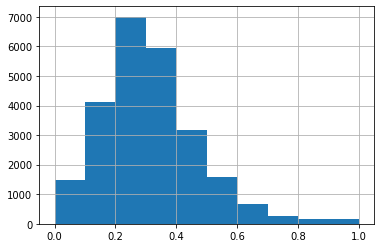

In [50]:
nba_df['FTr_NO'].hist() # Curiosamente a curva é bastante concentrada nos valores médio-baixos,
# e também com boa aparência de distribuição de algum fenômeno físico

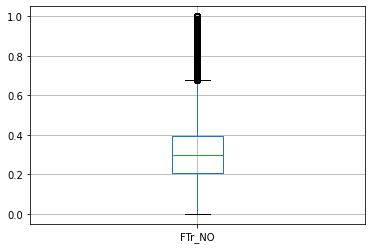

In [51]:
nba_df.boxplot('FTr_NO') # devido à média ser um valor relativamente baixo,
# com um desvio padrão relativamente alto, e como há uma quantidade de itens
# com valor acima de dois desvios padrão (e nenhum com abaixo de 2 desvio
# padrão = 0), uma boa quantidade de valores altos são considerados outliers.

Observação: o cálculo de médias de altura e de peso precisa ser contextualizado:
- a média de altura utilizando o dataframe nba_df fornece a média entre todos jogadores durante todas temporadas, mas não simplesmente a média entre todos jogadores. Isto ocorre porque alguns jogadores podem ter jogado temporadas a mais do que outros, significando que sua altura terá um 'peso' maior no cálculo da média
- a média de peso dos jogadores possui a mesma característica que a de altura, com a particularidade de que especificamente para ela ainda há uma limitação de coleta de dados: o peso de cada jogador foi coletado apenas uma vez, ao passo que ao longo de sua carreira o seu peso provavelmente alterará ao longo das temporadas

## Item 4: tratamento de valores ausentes nas seguintes labels:
(a) os mesmos campos numéricos height, weight, TS% e FTr, e também nos (b) campos categóricos birth_city, birth_state e collage

### (a) height, weight, TS% e FTr:
Substituir os valores ausentes pela média dos respectivos valores dos campos da série

#### Height

In [52]:
# Confirmando que há valores nulos em height_NO
nba_df['height_NO'].isnull().sum()

30

In [53]:
# Utilizaremos a coluna height_NO, onde os valores extremos já foram removidos.
height_mean = nba_df['height_NO'].mean()
height_mean


199.41489008060742

In [54]:
# Selecionando apenas os valores nulos de height_NO e atribuindo aos mesmos a média
# em uma label de height treated
nba_df['height_treat'] = np.where(nba_df['height_NO'].isnull(), height_mean, nba_df['height_NO'])

Uma alternativa mais simples seria o método .fillna

In [55]:
nba_df['height_fillna'] = nba_df['height_NO'].fillna(value=height_mean)
(nba_df['height_fillna'] == nba_df['height_treat']).all() # comparou todos valores de ambas séries e deu ok

True

In [56]:
# Conferindo se os valores nulos foram corrigidos
nba_df['height_treat'].isnull().sum() # = 0, ok

0

In [57]:
# Conferindo que a média não foi alterada
nba_df['height_treat'].mean() # média segue sendo 199,4 - ok

199.41489008060745

#### Weight

In [58]:
# Confirmando que há valores nulos em weight_NO
nba_df['weight_NO'].isnull().sum()

3

In [59]:
# Utilizaremos a coluna height_NO, onde os valores extremos já foram removidos.
weight_mean = nba_df['weight_NO'].mean()
weight_mean

95.53710104525263

In [60]:
# Preenchendo os valores nulos de weight_NO com a média
# em uma label de weight treated
nba_df['weight_treat'] = nba_df['weight_NO'].fillna(value=weight_mean)

In [61]:
# Conferindo se os valores nulos foram corrigidos
nba_df['weight_treat'].isnull().sum() # = 0, ok

0

In [62]:
# Conferindo que a média não foi alterada
nba_df['weight_treat'].mean() # média segue sendo 95,5 - ok

95.53710104525263

#### TS%

In [63]:
# Confirmando que há valores nulos em TS%_NO
nba_df['TS%_NO'].isnull().sum()

86

In [64]:
# Utilizaremos a coluna TS%_NO, onde os valores extremos já foram removidos.
TS_mean = nba_df['TS%_NO'].mean()
TS_mean

0.4925896965247217

In [65]:
# Preenchendo os valores nulos de TS%_NO com a média
# em uma label de weight treated
nba_df['TS%_treat'] = nba_df['TS%_NO'].fillna(value=TS_mean)

In [66]:
# Conferindo se os valores nulos foram corrigidos
nba_df['TS%_treat'].isnull().sum() # = 0, ok

0

In [67]:
# Conferindo que a média não foi alterada
nba_df['TS%_treat'].mean() # média segue sendo 0,492 - ok

0.49258969652472273

#### FTr

In [68]:
# Confirmando que há valores nulos em weight_NO
nba_df['FTr_NO'].isnull().sum()

99

In [69]:
# Utilizaremos a coluna height_NO, onde os valores extremos já foram removidos.
FTr_mean = nba_df['FTr_NO'].mean()
FTr_mean

0.31356842581547745

In [70]:
# Preenchendo os valores nulos de FTr_NO com a média
# em uma label de weight treated
nba_df['FTr_treat'] = nba_df['FTr_NO'].fillna(value=FTr_mean)

In [71]:
# Conferindo se os valores nulos foram corrigidos
nba_df['FTr_treat'].isnull().sum() # = 0, ok

0

In [72]:
# Conferindo que a média não foi alterada
nba_df['FTr_treat'].mean() # média segue sendo 0,313 - ok

0.31356842581547867

### (b) birth_city, birth_state e collage:
substituir valores ausentes por uma categoria padrão ("N.A.")

In [73]:
cat_padrao = "N.A."

#### Birth_city

In [74]:
# Como não trabalhamos com essa label até agora, uma breve avaliação da mesma inicialmente
nba_df['birth_city'].describe()

count       22978
unique       1264
top       Chicago
freq          753
Name: birth_city, dtype: object

In [75]:
# Confirmando que há valores nulos em birth_city
nba_df['birth_city'].isnull().sum()

1646

In [76]:
# Preenchendo os valores nulos de birth_city com a string padrão
nba_df['birth_city_treat'] = nba_df['birth_city'].fillna(value=cat_padrao)

In [77]:
# Conferindo se os valores nulos foram corrigidos
nba_df['birth_city_treat'].isnull().sum() # = 0, ok

0

In [78]:
# Conferindo se a descrição segue fazendo sentido
nba_df['birth_city_treat'].describe() # ok, somou-se um valor único 
# (a nova categoria) e ele se tornou justamente o valor mais frequente,
# pois havia mais nulos do que a categoria mais frequente (chicago)

count     24624
unique     1265
top        N.A.
freq       1646
Name: birth_city_treat, dtype: object

#### Birth_state

In [79]:
# Como não trabalhamos com essa label até agora, uma breve avaliação da mesma inicialmente
nba_df['birth_state'].describe()

count          22935
unique           128
top       California
freq            2293
Name: birth_state, dtype: object

In [80]:
# Confirmando que há valores nulos em birth_state
nba_df['birth_state'].isnull().sum()

1689

In [81]:
# Preenchendo os valores nulos de birth_state com a string padrão
nba_df['birth_state_treat'] = nba_df['birth_state'].fillna(value=cat_padrao)

In [82]:
# Conferindo se os valores nulos foram corrigidos
nba_df['birth_state_treat'].isnull().sum() # = 0, ok

0

In [83]:
# Conferindo se a descrição segue fazendo sentido
nba_df['birth_state_treat'].describe() # ok, somou-se um valor único 
# (a nova categoria) 

count          24624
unique           129
top       California
freq            2293
Name: birth_state_treat, dtype: object

#### Collage

In [84]:
# Como não trabalhamos com essa label até agora, uma breve avaliação da mesma inicialmente
nba_df['collage'].describe()

count                                     22401
unique                                      422
top       University of California, Los Angeles
freq                                        627
Name: collage, dtype: object

In [85]:
# Confirmando que há valores nulos em collage
nba_df['collage'].isnull().sum()

2223

In [86]:
# Preenchendo os valores nulos de collage com a string padrão
nba_df['collage_treat'] = nba_df['collage'].fillna(value=cat_padrao)

In [87]:
# Conferindo se os valores nulos foram corrigidos
nba_df['collage_treat'].isnull().sum() # = 0, ok

0

In [88]:
# Conferindo se a descrição segue fazendo sentido
nba_df['collage_treat'].describe() # ok, somou-se um valor único 
# (a nova categoria) e ele se tornou justamente o valor mais frequente,
# pois havia mais nulos do que a categoria mais frequente (UoC)

count     24624
unique      423
top        N.A.
freq       2223
Name: collage_treat, dtype: object

## Item 5: Discretização de Age
Discretizar o campo Age em três categorias: Júnior, médio e sênior. Para isso, avalie a 
distribuição e aplique a abordagem de divisão por largura igual, usando intervalos de 
percentis iguais: (0.333)

In [89]:
# Antes de iniciar a discretização, verificamos se há valores extremos que
# precisem ser tratados
nba_df['Age'].describe() # ta ok, não há 

count    24616.000000
mean        26.664405
std          3.841892
min         18.000000
25%         24.000000
50%         26.000000
75%         29.000000
max         44.000000
Name: Age, dtype: float64

In [90]:
nba_df['Age'].isnull().sum() # há 8 valores nulos - como sao apenas 8 de 24 mil,
# não nos prestaremos a criar uma coluna nova para removê-los e serão ignorados

8

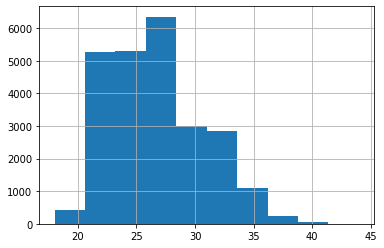

In [91]:
nba_df['Age'].hist()

In [92]:
# O exercicio solicita que sejam nomeados em três categorias com larguras iguais, 
# utilizaremos uma função para isso
def discrIdade(idade):
  if  idade < nba_df['Age'].quantile(1.0/3.0):
    return 'Júnior'
  elif idade < nba_df['Age'].quantile(2.0/3.0):
    return 'Médio'
  else:
    return 'Sênior'


In [93]:
# Aplicando então a função de discretização e analisando o resultado:
nba_df['Age_disc'] = nba_df['Age'].apply(discrIdade)
nba_df['Age_disc'].describe()

count     24624
unique        3
top       Médio
freq       9841
Name: Age_disc, dtype: object

## Análise dos dados
Respondendo algumas questões levantadas pelo professor

### 1 Qual a média de idade/peso dos jogadores?

Uma observação sobre estes cálculos: no mundo real, teríamos leituras potencialmente diferentes para altura e, especialmente, para peso dos jogadores a cada temporada. Entretanto, o valor de altura e de peso é único para cada jogador e replicado em todas as temporadas. Além disso, nem todos jogadores terão jogado o mesmo número de temporadas, significando que o peso e a altura de cada jogador não terá necessariamente o mesmo "peso" no cálculo da média abaixo. Isto gera uma potencial distorção dos valores, que será desconsiderada neste estudo.

In [94]:
# Média de idade dos jogadores: 
nba_df['height_treat'].mean()

199.41489008060745

In [95]:
# Média de peso dos jogadores: 
nba_df['weight_treat'].mean()

95.53710104525263

### 2 Compare as médias de idade e de peso dos jogadores na década de 50 com as médias na década de 90.
Observação: considerarei década como do ano 0 ao ano 9

In [96]:
# Criando subdataframes com altura e peso dos jogadores na decada de 50 e na decada de 90
nba_dec50_wh_df = nba_df[(1950 <= nba_df['Year']) & (nba_df['Year'] < 1960)][['height_treat', 'weight_treat']]
nba_dec90_wh_df = nba_df[(1990 <= nba_df['Year']) & (nba_df['Year'] < 2000)][['height_treat', 'weight_treat']]

In [97]:
pd.DataFrame(np.array([
              [50, nba_dec50_wh_df['height_treat'].mean(), nba_dec50_wh_df['weight_treat'].mean()], 
              [90, nba_dec90_wh_df['height_treat'].mean(), nba_dec90_wh_df['weight_treat'].mean()]
                      ]),
             columns=['Década', 'Média de Altura', 'Média de peso'])

,Década,Média de Altura,Média de peso
0,50.0,193.769655,88.691793
1,90.0,200.051866,95.670579


Percebe-se que houve um aumento de 7cm na média de altura dos jogadores da nba da década de 50 para década de 90 e um consequente aumento de peso também.

### 3 Qual jogador marcou mais pontos na série histórica?
Desconsiderar ano e time

In [98]:
# Label PTS no nba_df é o que indica quantos pontos o jogador marcou
nba_df.groupby(by='Player')['PTS'].sum().sort_values(ascending=False).head(5)
# Resultado ok: foi o Kareem mesmo
# http://www.espn.com/nba/history/leaders
# OBS: O Lebron tá chegando lá, mas não tava na tabela

Player
Kareem Abdul-Jabbar*    38387
Karl Malone*            36928
Wilt Chamberlain*       33953
Kobe Bryant             33643
Michael Jordan*         32292
Name: PTS, dtype: int64

### 4 Qual jogador marcou mais pontos em uma temporada e qual foi o ano?

In [99]:
nba_df.groupby(by=['Player', 'Year'])['PTS'].sum().sort_values(ascending=False)
# https://en.wikipedia.org/wiki/List_of_National_Basketball_Association_annual_scoring_leaders#:~:text=Wilt%20Chamberlain%20holds%20the%20all,in%20the%201961%E2%80%9362%20season.
# Corretamente, foi o Wilt Chamberlain, porém a temporada correta foi 1962, com os 4029 calculados.
# Segundo o Wikipedia, o Chamberlain marcou 2534 em 1965. https://en.wikipedia.org/wiki/1964%E2%80%9365_NBA_season
# Por que será que a pontuação de 1965 foi calculada em dobro?

Player             Year
Wilt Chamberlain*  1965    5068
                   1962    4029
Carmelo Anthony    2011    3940
DeMarcus Cousins   2017    3884
Archie Clark       1972    3876
                           ... 
Hassan Whiteside   2011       0
Derrick Phelps     1995       0
Leo Rautins        1985       0
Ray Radziszewski   1958       0
Olden Polynice     2004       0
Name: PTS, Length: 20286, dtype: int64

In [100]:
nba_df[nba_df['Player']=='Wilt Chamberlain*'][['Year', 'PTS']]
# Tá explicado, ele mudou de clube em 1965 e o df contém uma linha para
# os pontos em cada clube e um para a soma, por isto a soma fica dobrada
# Isso significa que se não fosse o Google eu teria levado adiante a 
# informação incorreta por não saber que isso está duplicado

,Year,PTS
1901,1960,2707
1902,1961,3033
1903,1962,4029
1904,1963,3586
1905,1964,2948
1906,1965,2534
1907,1965,1480
1908,1965,1054
1909,1966,2649
1910,1967,1956


In [101]:
nba_df[nba_df['Player']=='Wilt Chamberlain*'][nba_df['Year']==1965]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight,collage,born,birth_city,birth_state,height_NO,weight_NO,TS%_NO,FTr_NO,height_treat,height_fillna,weight_treat,TS%_treat,FTr_treat,birth_city_treat,birth_state_treat,collage_treat,Age_disc
1906,1965,Wilt Chamberlain*,C,28.0,TOT,73,NaN,3301.0,28.6,0.513,NaN,0.422,NaN,NaN,NaN,13.8,NaN,NaN,NaN,NaN,NaN,9.6,5.5,15.1,0.219,NaN,NaN,NaN,NaN,NaN,1063,2083,0.510,NaN,NaN,NaN,1063,2083,0.510,0.510,408,880,0.464,NaN,NaN,1673.0,250,NaN,NaN,NaN,146,2534,216.0,124.0,University of Kansas,1936.0,Philadelphia,Pennsylvania,216.0,124.0,0.513,0.422,216.0,216.0,124.0,0.513,0.422,Philadelphia,Pennsylvania,University of Kansas,Sênior
1907,1965,Wilt Chamberlain*,C,28.0,SFW,38,NaN,1743.0,29.8,0.495,NaN,0.392,NaN,NaN,NaN,13.6,NaN,NaN,NaN,NaN,NaN,4.3,3.2,7.5,0.208,NaN,NaN,NaN,NaN,NaN,636,1275,0.499,NaN,NaN,NaN,636,1275,0.499,0.499,208,500,0.416,NaN,NaN,893.0,117,NaN,NaN,NaN,76,1480,216.0,124.0,University of Kansas,1936.0,Philadelphia,Pennsylvania,216.0,124.0,0.495,0.392,216.0,216.0,124.0,0.495,0.392,Philadelphia,Pennsylvania,University of Kansas,Sênior
1908,1965,Wilt Chamberlain*,C,28.0,PHI,35,NaN,1558.0,27.3,0.540,NaN,0.470,NaN,NaN,NaN,14.1,NaN,NaN,NaN,NaN,NaN,5.3,2.3,7.6,0.233,NaN,NaN,NaN,NaN,NaN,427,808,0.528,NaN,NaN,NaN,427,808,0.528,0.528,200,380,0.526,NaN,NaN,780.0,133,NaN,NaN,NaN,70,1054,216.0,124.0,University of Kansas,1936.0,Philadelphia,Pennsylvania,216.0,124.0,0.540,0.470,216.0,216.0,124.0,0.540,0.470,Philadelphia,Pennsylvania,University of Kansas,Sênior


### 5 Qual jogador jogou por mais tempo na NBA?

In [102]:
nba_df.groupby(by=['Player'])['Year'].count().sort_values(ascending=False)
# Lembrando do item anterior, este código tem um problema porque em ano de mudança
# de clube o jogador terá mais de uma entrada naquele ano. Preciso utilizar apenas
# valores únicos.
# De fato, segundo o link abaixo, o jogador que jogou mais temporadas foi
# o Vince Carter com 22 temporadas
# https://www.one37pm.com/strength/sports/longest-nba-career-kobe-bryant

Player
Eddie Johnson       33
Mike Dunleavy       32
Gerald Henderson    29
Nazr Mohammed       28
Kevin Willis        27
                    ..
Gundars Vetra        1
Guy Morgan           1
Guy Rucker           1
Hal Lear             1
Joby Wright          1
Name: Year, Length: 3921, dtype: int64

In [103]:
# Este código deveria dar a soma da quantitade de valores únicos de ano de cada jogador
nba_df.groupby(by=['Player']).nunique()['Year'].sort_values(ascending=False)
# Somou correto Kevin Garnett e Kevin Willis com 21 temporadas cada, porém o 
# número de temporadas dos três primeiros está incorreto e está faltando o
# Vince Carter com 22 temporadas

Player
Mike Dunleavy    26
John Lucas       22
Eddie Johnson    21
Kevin Garnett    21
Kevin Willis     21
                 ..
Elias Harris      1
Patrick Eddie     1
Elmer Behnke      1
Elmer Gainer      1
Joby Wright       1
Name: Year, Length: 3921, dtype: int64

##### Estudando cadê o Vince Carter

In [104]:
# Tentando entender por que não apareceu o Vince Carter, verifico se ele está no df
nba_df[nba_df['Player']=='Vince Carter'] # OK, ele está no DF, mas só até 2017

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,height,weight,collage,born,birth_city,birth_state,height_NO,weight_NO,TS%_NO,FTr_NO,height_treat,height_fillna,weight_treat,TS%_treat,FTr_treat,birth_city_treat,birth_state_treat,collage_treat,Age_disc
16627,1999,Vince Carter,SF,22.0,TOR,50,49.0,1760.0,19.6,0.516,0.086,0.350,6.1,12.6,9.3,17.2,1.7,3.3,11.1,25.6,NaN,3.6,1.4,5.0,0.136,NaN,2.1,-0.2,1.9,1.7,345,766,0.450,19.0,66.0,0.288,326,700,0.466,0.463,204,268,0.761,94.0,189.0,283.0,149,55.0,77.0,110.0,140,913,198.0,99.0,University of North Carolina,1977.0,Daytona Beach,Florida,198.0,99.0,0.516,0.350,198.0,198.0,99.0,0.516,0.350,Daytona Beach,Florida,University of North Carolina,Júnior
16628,2000,Vince Carter,SF,23.0,TOR,82,82.0,3126.0,23.4,0.543,0.139,0.325,5.2,12.1,8.5,20.5,1.8,2.1,8.4,30.0,NaN,9.1,2.7,11.8,0.182,NaN,5.2,-0.6,4.6,5.2,788,1696,0.465,95.0,236.0,0.403,693,1460,0.475,0.493,436,551,0.791,150.0,326.0,476.0,322,110.0,92.0,178.0,263,2107,198.0,99.0,University of North Carolina,1977.0,Daytona Beach,Florida,198.0,99.0,0.543,0.325,198.0,198.0,99.0,0.543,0.325,Daytona Beach,Florida,University of North Carolina,Júnior
16629,2001,Vince Carter,SF,24.0,TOR,75,75.0,2979.0,25.0,0.551,0.240,0.303,6.5,9.3,7.9,19.2,2.0,1.9,8.2,30.7,NaN,10.3,2.6,12.9,0.208,NaN,7.7,-0.6,7.0,6.8,762,1656,0.460,162.0,397.0,0.408,600,1259,0.477,0.509,384,502,0.765,176.0,240.0,416.0,291,114.0,82.0,167.0,205,2070,198.0,99.0,University of North Carolina,1977.0,Daytona Beach,Florida,198.0,99.0,0.551,0.303,198.0,198.0,99.0,0.551,0.303,Daytona Beach,Florida,University of North Carolina,Médio
16630,2002,Vince Carter,SG,25.0,TOR,60,60.0,2385.0,20.5,0.515,0.239,0.235,6.4,8.7,7.5,19.9,2.1,1.3,9.6,30.5,NaN,4.6,2.4,7.0,0.140,NaN,4.8,-0.7,4.1,3.7,559,1307,0.428,121.0,313.0,0.387,438,994,0.441,0.474,245,307,0.798,138.0,175.0,313.0,239,94.0,43.0,154.0,191,1484,198.0,99.0,University of North Carolina,1977.0,Daytona Beach,Florida,198.0,99.0,0.515,0.235,198.0,198.0,99.0,0.515,0.235,Daytona Beach,Florida,University of North Carolina,Médio
16631,2003,Vince Carter,SG,26.0,TOR,43,42.0,1471.0,21.9,0.532,0.172,0.211,4.4,10.4,7.3,20.4,1.7,2.0,8.2,28.1,NaN,3.4,0.8,4.2,0.136,NaN,4.1,-1.4,2.7,1.7,355,760,0.467,45.0,131.0,0.344,310,629,0.493,0.497,129,160,0.806,59.0,129.0,188.0,143,48.0,41.0,74.0,121,884,198.0,99.0,University of North Carolina,1977.0,Daytona Beach,Florida,198.0,99.0,0.532,0.211,198.0,198.0,99.0,0.532,0.211,Daytona Beach,Florida,University of North Carolina,Médio
16632,2004,Vince Carter,SG,27.0,TOR,73,73.0,2785.0,20.0,0.501,0.167,0.286,3.9,10.6,7.2,28.0,1.7,1.7,12.0,32.5,NaN,2.6,3.4,6.0,0.103,NaN,2.9,0.1,2.9,3.4,608,1457,0.417,93.0,243.0,0.383,515,1214,0.424,0.449,336,417,0.806,95.0,254.0,349.0,348,88.0,65.0,223.0,212,1645,198.0,99.0,University of North Carolina,1977.0,Daytona Beach,Florida,198.0,99.0,0.501,0.286,198.0,198.0,99.0,0.501,0.286,Daytona Beach,Florida,University of North Carolina,Médio
16633,2005,Vince Carter,SF-SG,28.0,TOT,77,76.0,2828.0,22.9,0.541,0.203,0.299,4.4,12.6,8.4,25.7,2.1,1.3,8.8,31.6,NaN,5.9,3.5,9.4,0.159,NaN,5.3,0.0,5.3,5.2,696,1541,0.452,127.0,313.0,0.406,569,1228,0.463,0.493,367,460,0.798,106.0,295.0,401.0,327,109.0,48.0,168.0,243,1886,198.0,99.0,University of North Carolina,1977.0,Daytona Beach,Florida,198.0,99.0,0.541,0.299,198.0,198.0,99.0,0.541,0.299,Daytona Beach,Florida,University of North Carolina,Sênior
16634,2005,Vince Carter,SG,28.0,TOR,20,20.0,608.0,17.0,0.475,0.195,0.238,5.1,7.2,6.1,18.5,2.1,1.8,6.2,26.7,NaN,0.5,0.4,0.9,0.068,NaN,1.2,-1.1,0.1,0.3,124,302,0.411,19.0,59.0,0.322,105,243,0.432,0.442,50,72,0.694,28.0,38.0,66.0,61,25.0,15.0,22.0,56,317,198.0,99.0,University of North Carolina,1977.0,Daytona Beach,Florida,198.0,99.0,0.475,0.238,198.0,198.0,99.0,0.475,0.238,Daytona Beach,Florida,University of North Carolina,Sênior
16635,2005,Vince Carter,SF,28.0,NJN,

In [105]:
years_nba = pd.unique(nba_df['Year'])
years_nba.sort()
years_nba
# O próprio df só tem dados até 2017, e o Vince Carter chegou a 22 temporadas
# em 2021, então OK não ter aparecido na lista acima

array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017])

##### Estudando Mike Dunleavy com 26

In [106]:
# Verificando quais temporadas constam na carreira dele
nba_df[nba_df['Player']=='Mike Dunleavy']['Year']
# Olha só, entre 1977-90 e depois 2003-17, devem ser dois jogadores diferentes

5803    1977
5804    1978
5805    1978
5806    1978
5807    1979
5808    1980
5809    1981
5810    1982
5811    1983
5812    1984
5813    1985
5814    1989
5815    1990
5816    2003
5817    2004
5818    2005
5819    2006
5820    2007
5821    2007
5822    2007
5823    2008
5824    2009
5825    2010
5826    2011
5827    2012
5828    2013
5829    2014
5830    2015
5831    2016
5832    2017
5833    2017
5834    2017
Name: Year, dtype: int64

In [107]:
# Verificando se são dois jogadores diferentes de acordo com a data de nascimento
nba_df[nba_df['Player']=='Mike Dunleavy'][['Year', 'born']]

,Year,born
5803,1977,1954.0
5804,1978,1954.0
5805,1978,1954.0
5806,1978,1954.0
5807,1979,1954.0
5808,1980,1954.0
5809,1981,1954.0
5810,1982,1954.0
5811,1983,1954.0
5812,1984,1954.0


Este resultado foi muito estranho, não tem como estar jogando a NBA com 60 anos de idade. 
Pesquisei no Wikipedia, e o jogador dos anos 70/80 é nascido em 1954 de fato, Mike Dunleavy Sr., pai do Mike Dunleavy Jr., nascido em 1980 e que jogou a partir de 2003. 
A própria planilha JOGADORES_NBA está incorreta pois consta apenas um Mike Dunleavy, já a planilha de métricas lista ambos com o mesmo nome e sem outro diferenciador.

##### Estudando John Lucas com 22

In [108]:
# Verificando novamente assim como para o Mike
nba_df[nba_df['Player']=='John Lucas']['Year']
# Mesma coisa, na década de 70/80 houve o John Lucas II, e nos anos 2000 o John Lucas III

6098    1977
6099    1978
6100    1979
6101    1980
6102    1981
6103    1982
6104    1983
6105    1984
6106    1985
6107    1986
6108    1987
6109    1988
6110    1989
6111    1990
6112    2006
6113    2007
6114    2011
6115    2012
6116    2013
6117    2014
6118    2015
6119    2017
Name: Year, dtype: int64

##### Estudando Eddie Johnson com 21

In [109]:
# Verificando o Eddie Johnson
nba_df[nba_df['Player']=='Eddie Johnson']['Year']
# Em relação ao período, poderia ser apenas 1 jogador.
# Porém, segundo o Wikipedia, ele jogou na NBA apenas 
# de 1981 a 1999. Será que é o mesmo?

6639    1978
6640    1979
6641    1980
6642    1981
6643    1982
6644    1982
6645    1983
6646    1983
6647    1984
6648    1984
6649    1985
6650    1985
6651    1986
6652    1986
6653    1986
6654    1986
6655    1987
6656    1987
6657    1988
6658    1989
6659    1990
6660    1991
6661    1991
6662    1991
6663    1992
6664    1993
6665    1994
6666    1996
6667    1997
6668    1997
6669    1997
6670    1998
6671    1999
Name: Year, dtype: int64

In [110]:
# Verificando pela idade, em cada ano a partir de 1982 há idades diferentes,
# parecem ser jogadores diferentes mesmo... então agrupar pela idade pode ser
# uma boa maneira de tentar diferenciar os jogadores de mesmo nome 
nba_df[nba_df['Player']=='Eddie Johnson'][['Year','Age']]

,Year,Age
6639,1978,22.0
6640,1979,23.0
6641,1980,24.0
6642,1981,25.0
6643,1982,26.0
6644,1982,22.0
6645,1983,27.0
6646,1983,23.0
6647,1984,28.0
6648,1984,24.0


#### 5 ... retomando
Acima, percebe-se que há jogadores homônimos na liga, inclusive concomitantemente, e que o banco JOGADORES_NBA lista apenas 1 deles, ao passo que o METRICAS_NBA, como possui a idade de cada jogador a cada ano, pode ser capaz de diferenciar os jogadores com a idade. 

In [111]:
# Terei que retomar isso depois, porque dificultou um pouco mais

### 6 Qual jogador permaneceu mais tempo em um mesmo time? Qual time e por quanto tempo ficou?

In [112]:
# LABEL que representa o time: Tm
# Agruparemos por jogador e então por time, e então contaremos a quantidade de anos em cada time.
nba_df.groupby(['Player', 'Tm'])['Year'].count().sort_values(ascending=False).head(5)

Player          Tm 
Kobe Bryant     LAL    20
Tim Duncan      SAS    19
John Stockton*  UTA    19
Dirk Nowitzki   DAL    19
Karl Malone*    UTA    18
Name: Year, dtype: int64

### 7 Quais são os cinco atletas mais altos e mais baixos que já jogaram na NBA?

In [113]:
# JOGADORES MAIS ALTOS

# Selecionando apenas jogadores e suas alturas, então agrupando por jogadores.
  # Após, selecionando o valor máximo de altura que cada jogador teve (neste 
  # df todos os valores de altura são iguais, mas poderiam ter sido valores 
  # diferentes), e finalmente selecionando as 5 maiores alturas
nba_df[['Player','height_treat']].groupby('Player').max().nlargest(5, columns='height_treat')



,height_treat
Player,
Gheorghe Muresan,231.0
Manute Bol,231.0
P.J. Brown,229.0
Shawn Bradley,229.0
Yao Ming*,229.0


In [114]:
type(nba_df[['Player','height_treat']].groupby('Player').max())

pandas.core.frame.DataFrame

In [115]:
# Um código mais simples para responder esta pergunta e também as abaixo é este,
# porém não consegui encontrar a sintaxe correta com essa simplicidade e acabei
# precisando complicar. Porém, me parece que o meu código comportaria encontrar
# o valor caso alterasse de ano a ano e este talvez não
nba_df.groupby('Player')['height_treat'].max().sort_values(ascending=False).head(5)

Player
Gheorghe Muresan    231.0
Manute Bol          231.0
Shawn Bradley       229.0
Yao Ming*           229.0
P.J. Brown          229.0
Name: height_treat, dtype: float64

In [116]:
type(nba_df.groupby('Player')['height_treat'].max())

pandas.core.series.Series

In [117]:
# JOGADORES MAIS BAIXOS

# Selecionando apenas jogadores e suas alturas, então agrupando por jogadores.
  # Após, selecionando o valor mínimo de altura que cada jogador teve (neste 
  # df todos os valores de altura são iguais, mas poderiam ter sido valores 
  # diferentes), e finalmente selecionando as 5 menores alturas
nba_df[['Player','height_treat']].groupby('Player').min().nsmallest(5, columns='height_treat')

,height_treat
Player,
Muggsy Bogues,160.0
Earl Boykins,165.0
Spud Webb,168.0
Greg Grant,170.0
Keith Jennings,170.0


### 8 Quais são os cinco atletas mais pesados e mais leves que já jogaram na NBA?

In [118]:
# JOGADORES MAIS PESADOS

# Selecionando apenas jogadores e seus pesos, então agrupando por jogadores.
  # Após, selecionando o valor máximo de peso que cada jogador teve (neste 
  # df todos os valores de peso são iguais, mas poderiam ter sido valores 
  # diferentes), e finalmente selecionando os 5 maiores pesos
nba_df[['Player','weight_treat']].groupby('Player').max().nlargest(5, columns='weight_treat')

,weight_treat
Player,
Sim Bhullar,163.0
Thomas Hamilton,149.0
Priest Lauderdale,147.0
Shaquille O'Neal*,147.0
Garth Joseph,142.0


In [119]:
# JOGADORES MAIS LEVES

# Selecionando apenas jogadores e seus pesos, então agrupando por jogadores.
  # Após, selecionando o valor mínimo de pesos que cada jogador teve (neste 
  # df todos os valores de altura são iguais, mas poderiam ter sido valores 
  # diferentes), e finalmente selecionando os 5 menores pesos
nba_df[['Player','weight_treat']].groupby('Player').min().nsmallest(5, columns='weight_treat')

,weight_treat
Player,
Spud Webb,60.0
Earl Boykins,61.0
Muggsy Bogues,61.0
Greg Grant,63.0
Elliot Perry,68.0


# EXERCICIO 3.3 - Ramen Ratings
fonte: 
https://www.kaggle.com/residentmario/ramen-ratings

In [120]:
# Importando o arquivo .xlsx em um pandas DataFrame e visualizando o cabeçalho do df resultante
ramen_df  = pd.read_excel(folder_gdrive + 'RAMEN_RATINGS.xlsx')
ramen_df.head(5)

,Review #,Brand,Variety,Style,Country,Stars
0,2580.0,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75
1,2579.0,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1.00
2,2578.0,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25
3,2577.0,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75
4,2576.0,Ching's Secret,Singapore Curry,Pack,India,3.75


## Análise de dados

### Item 1: Qual país tem melhor avaliação média? E mediana? Os diferentes resultados sugerem erro nos dados (outliers)?

In [124]:
# Selecionaremos as labels país e avaliação, agrupando-as por país e geraremos 
# a análise estatística describe das avaliações de cada país (o que gera um DF)
ramen_starspcntry_df = ramen_df[['Country', 'Stars']].groupby('Country').describe()
ramen_starspcntry_df.head(5)

Stars                                                   
           count      mean       std   min    25%   50%    75%  max
Country                                                            
Australia   22.0  3.138636  0.895216  1.00  2.750  3.00  3.875  5.0
Bangladesh   7.0  3.714286  0.365963  3.25  3.375  4.00  4.000  4.0
Brazil       5.0  4.350000  0.418330  4.00  4.000  4.25  4.500  5.0
Cambodia     5.0  4.200000  0.758288  3.50  3.500  4.00  5.000  5.0
Canada      41.0  2.243902  1.296013  0.00  1.500  2.25  3.000  5.0

In [125]:
# O df resultante ficou com multiindex nas colunas (conceito que precisei aprender),
# entao removeremos o primeiro nivel de indexação
ramen_starspcntry_df = ramen_starspcntry_df.droplevel(level=0,axis=1)
ramen_starspcntry_df.head(5)

,count,mean,std,min,25%,50%,75%,max
Country,,,,,,,,
Australia,22.0,3.138636,0.895216,1.00,2.750,3.00,3.875,5.0
Bangladesh,7.0,3.714286,0.365963,3.25,3.375,4.00,4.000,4.0
Brazil,5.0,4.350000,0.418330,4.00,4.000,4.25,4.500,5.0
Cambodia,5.0,4.200000,0.758288,3.50,3.500,4.00,5.000,5.0
Canada,41.0,2.243902,1.296013,0.00,1.500,2.25,3.000,5.0


In [128]:
# Este código é mais simples porque evita o problema de multiindex
# das colunas, que levei um bom tempo de pesquisa para resolver.
# Em todos exercícios, sofri bastante por não ter lembrado de 
# utilizar a seleção de dados com colchetes logo após o groupby.
ramen_starspcntry_df = ramen_df.groupby('Country')['Stars'].describe()
ramen_starspcntry_df.head(5)

,count,mean,std,min,25%,50%,75%,max
Country,,,,,,,,
Australia,22.0,3.138636,0.895216,1.00,2.750,3.00,3.875,5.0
Bangladesh,7.0,3.714286,0.365963,3.25,3.375,4.00,4.000,4.0
Brazil,5.0,4.350000,0.418330,4.00,4.000,4.25,4.500,5.0
Cambodia,5.0,4.200000,0.758288,3.50,3.500,4.00,5.000,5.0
Canada,41.0,2.243902,1.296013,0.00,1.500,2.25,3.000,5.0


In [129]:
# Agora é possível ordenar os valores para encontrar a avaliação mais alta
ramen_starspcntry_df.sort_values('mean', ascending=False).head(5)
# Coréia do Sul está com a média de avaliações mais alta, porém tanto este
# país quanto Japão e EUA possuem valores extremos, incorretos no contexto
# de que a avaliação deveria ir de 0 a 5.

,count,mean,std,min,25%,50%,75%,max
Country,,,,,,,,
South Korea,309.0,27.205340,293.640192,0.0,3.5,3.75,4.25,4125.0
Japan,352.0,15.688636,219.652941,0.0,3.5,4.00,4.75,4125.0
USA,323.0,10.029412,118.050275,0.0,3.0,3.75,4.00,2125.0
Brazil,5.0,4.350000,0.418330,4.0,4.0,4.25,4.50,5.0
Sarawak,3.0,4.333333,0.577350,4.0,4.0,4.00,4.50,5.0


In [130]:
# Ordenando pela mediana
ramen_starspcntry_df.sort_values('50%', ascending=False).head(5)
# O brasil é o que possui a mediana de avaliações mais alta
# - porém, há apenas 5 avaliações.

,count,mean,std,min,25%,50%,75%,max
Country,,,,,,,,
Brazil,5.0,4.350000,0.418330,4.0,4.0,4.250,4.5,5.0
Malaysia,156.0,4.127564,0.878218,0.0,3.5,4.125,5.0,5.0
Singapore,109.0,4.126147,0.764992,2.0,3.5,4.000,5.0,5.0
Cambodia,5.0,4.200000,0.758288,3.5,3.5,4.000,5.0,5.0
Mexico,25.0,3.730000,0.483692,3.0,3.5,4.000,4.0,5.0


#### Remoção de valores extremos de avaliação
O prof. não solicitou como parte do exercício, porém acho interessante para praticar aproveitar este dataset e remover os valores extremos

In [131]:
# Iniciando com uma breve análise estatística dos dados de avaliação
ramen_df['Stars'].describe()
# Percebe-se que parece haver uma lógica de as avaliações irem de 0 a 5,
# não parece haver valores extremos no limite inferior, então devemos 
# corrigir os valores extremos do limite superior. 

count    2580.000000
mean        8.877752
std       136.632896
min         0.000000
25%         3.250000
50%         3.750000
75%         4.250000
max      4125.000000
Name: Stars, dtype: float64

Há várias opções de correções que podem ser feitas, tais como substituir:
- pela média/mediana global de avaliações
- pela média/mediana de cada país
- pela média/mediana de cada marca
- pela média/mediana de cada marca em cada país
- por valor nulo
- etc.


Neste caso, substituiremos pela mediana de cada país.

ainda não rolous.

In [132]:
# Portanto, iniciando removendo coluna Review # que atrapalharia e agrupando por país
ramen_gpb_cntry_df = ramen_df.drop('Review #', axis='columns').groupby('Country')

In [133]:
def rmv_xtrme(dfin):
  dfout = np.where(dfin['Stars'] > 5.0, 
                  dfin.median(), 
                  dfin['Stars']) # Valores acima do máximo substituídos pela média
  return dfout

In [134]:
type(ramen_gpb_cntry_df.apply(rmv_xtrme))
#ramen_df['Stars_NoExtrm'] = ramen_gpb_cntry_df.apply(rmv_xtrme)
#ramen_df

pandas.core.series.Series

In [135]:
#ramen_gpb_cntry_extrmvd_df = ramen_df.drop(['Review #', 'Stars'], axis='columns').groupby('Country')
#ramen_gpb_cntry_extrmvd_df.mean()

### Item 2: A marca "Nissin" é melhor avaliada em qual país (mediana)?

In [136]:
# Selecionando apenas as linhas em que a marca é Nissin e então 
# repetindo o agrupamento realizado no item anterior
ramen_nissin_eval_df = ramen_df[ramen_df['Brand']=='Nissin'][['Country', 'Stars']].groupby('Country').describe()
# Como este processo gerou colunas com multiindex, já vamos remover o primeiro nível
ramen_nissin_eval_df = ramen_nissin_eval_df.droplevel(level=0,axis=1)

In [137]:
# Ordenando pela mediana para verificar onde está a maior avaliação
ramen_nissin_eval_df.sort_values('50%', ascending=False).head(5)

,count,mean,std,min,25%,50%,75%,max
Country,,,,,,,,
Japan,111.0,4.259910,0.781572,2.00,3.75,4.50,5.00,5.0
Brazil,5.0,4.350000,0.418330,4.00,4.00,4.25,4.50,5.0
Hong Kong,67.0,4.141791,0.682886,1.75,3.75,4.00,5.00,5.0
Mexico,18.0,3.777778,0.499182,3.00,3.50,4.00,4.00,5.0
Singapore,27.0,4.092593,0.620748,3.00,3.75,4.00,4.75,5.0


### Item 3: No geral, qual tipo de embalagem é melhor avaliada (mediana)?

In [138]:
# Repetindo a mesma sequência de códigos dos itens anteriores
ramen_packing_df = ramen_df[['Style', 'Stars']].groupby('Style').describe()
ramen_packing_df = ramen_packing_df.droplevel(level=0,axis=1)
ramen_packing_df.sort_values('50%', ascending=False).head(5)

,count,mean,std,min,25%,50%,75%,max
Style,,,,,,,,
Bar,1.0,5.000000,NaN,5.0,5.0000,5.00,5.00,5.0
Box,6.0,4.291667,1.400149,1.5,4.4375,5.00,5.00,5.0
Bowl,481.0,18.728378,235.493872,0.0,3.2500,3.75,4.50,4125.0
Pack,1531.0,3.693207,0.995419,0.0,3.2500,3.75,4.25,5.0
Tray,108.0,41.701389,396.589219,0.0,3.0000,3.75,4.25,4125.0


## Pré-processamento dos dados:
Serão realizadas algumas operações para preparar os dados para treinar um modelo de ML que aceita apenas variáveis numéricas a prever a variável "Stars"

### Item 1: Remover variáveis "Review #" e "Variety"

In [139]:
ramen_ML_df = ramen_df.drop(labels=['Review #', 'Variety'], axis='columns')
ramen_ML_df.head(5)

,Brand,Style,Country,Stars
0,New Touch,Cup,Japan,3.75
1,Just Way,Pack,Taiwan,1.00
2,Nissin,Cup,USA,2.25
3,Wei Lih,Pack,Taiwan,2.75
4,Ching's Secret,Pack,India,3.75


### Item 2: Aplique codificação one-hot sobre as demais variáveis (exceto "Stars").

In [140]:
# One-hot: traduz uma label categórica de X valores em X labels binárias

# Iniciando com Brand
ramen_ML_df = pd.concat([pd.get_dummies(ramen_ML_df['Brand']), ramen_ML_df], axis=1)
ramen_ML_df.head(5)
# aqui já fica praticamente inviável visualizar o df, porque passamos de 4 para 359 colunas

,1 To 3 Noodles,7 Select,7 Select/Nissin,A-One,A-Sha Dry Noodle,A1,ABC,Acecook,Adabi,Ah Lai,Ajinatori,Amianda,Amino,Annie Chun's,Aroi,Asia Gold,Asian Thai Foods,Authentically Asian,Azami,Baijia,Baixiang Noodles,Baltix,Bamee,Batchelors,Binh Tay,Bon Go Jang,Bonasia,Boss,CJ CheilJedang,Campbell's,Cap Atoom Bulan,CarJEN,Chaudhary's Wai Wai,Chencun,Chering Chang,Chewy,Chikara,China Best,Ching's Secret,Chorip Dong,...,Unif,Unif / Tung-I,Unif Tung-I,Unif-100,United,Unox,Unzen,Urban Noodle,Ve Wong,Vedan,Vifon,Vina Acecook,Vit's,Wai Wai,Wang,Weh Lih,Wei Chuan,Wei Lih,Wei Wei,Westbrae,Western Family,World O' Noodle,Wu Mu,Wu-Mu,Wugudaochang,Xiao Ban Mian,Xiuhe,Yamachan,Yamadai,Yamamori,Yamamoto,Yum Yum,Yum-Mie,Zow Zow,iMee,iNoodle,Brand,Style,Country,Stars
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,New Touch,Cup,Japan,3.75
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Just Way,Pack,Taiwan,1.00
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Nissin,Cup,USA,2.25
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wei Lih,Pack,Taiwan,2.75
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Ching's Secret,Pack,India,3.75


Obs: observei que, caso a label que foi codificada não seja já removida, existe o risco de executar duas vezes o código durante os testes por engano e acrescentar labels dobradas sem se perceber. O ideal seria realizar o código como a seguir: 

> ramen_ML_df = pd.concat([pd.get_dummies(ramen_ML_df['Brand']), ramen_ML_df], axis=1).drop(labels='Brand', axis=1)



In [141]:
# A seguir, Style
ramen_ML_df = pd.concat([pd.get_dummies(ramen_ML_df['Style']), ramen_ML_df], axis=1)
ramen_ML_df.head(5)

,Bar,Bowl,Box,Can,Cup,Pack,Tray,1 To 3 Noodles,7 Select,7 Select/Nissin,A-One,A-Sha Dry Noodle,A1,ABC,Acecook,Adabi,Ah Lai,Ajinatori,Amianda,Amino,Annie Chun's,Aroi,Asia Gold,Asian Thai Foods,Authentically Asian,Azami,Baijia,Baixiang Noodles,Baltix,Bamee,Batchelors,Binh Tay,Bon Go Jang,Bonasia,Boss,CJ CheilJedang,Campbell's,Cap Atoom Bulan,CarJEN,Chaudhary's Wai Wai,...,Unif,Unif / Tung-I,Unif Tung-I,Unif-100,United,Unox,Unzen,Urban Noodle,Ve Wong,Vedan,Vifon,Vina Acecook,Vit's,Wai Wai,Wang,Weh Lih,Wei Chuan,Wei Lih,Wei Wei,Westbrae,Western Family,World O' Noodle,Wu Mu,Wu-Mu,Wugudaochang,Xiao Ban Mian,Xiuhe,Yamachan,Yamadai,Yamamori,Yamamoto,Yum Yum,Yum-Mie,Zow Zow,iMee,iNoodle,Brand,Style,Country,Stars
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,New Touch,Cup,Japan,3.75
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Just Way,Pack,Taiwan,1.00
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Nissin,Cup,USA,2.25
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wei Lih,Pack,Taiwan,2.75
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Ching's Secret,Pack,India,3.75


In [142]:
# Por último, Country
ramen_ML_df = pd.concat([pd.get_dummies(ramen_ML_df['Country']), ramen_ML_df], axis=1)
ramen_ML_df.head(5)

,Australia,Bangladesh,Brazil,Cambodia,Canada,China,Colombia,Dubai,Estonia,Fiji,Finland,Germany,Ghana,Holland,Hong Kong,Hungary,India,Indonesia,Japan,Malaysia,Mexico,Myanmar,Nepal,Netherlands,Nigeria,Pakistan,Philippines,Poland,Sarawak,Singapore,South Korea,Sweden,Taiwan,Thailand,UK,USA,United States,Vietnam,Bar,Bowl,...,Unif,Unif / Tung-I,Unif Tung-I,Unif-100,United,Unox,Unzen,Urban Noodle,Ve Wong,Vedan,Vifon,Vina Acecook,Vit's,Wai Wai,Wang,Weh Lih,Wei Chuan,Wei Lih,Wei Wei,Westbrae,Western Family,World O' Noodle,Wu Mu,Wu-Mu,Wugudaochang,Xiao Ban Mian,Xiuhe,Yamachan,Yamadai,Yamamori,Yamamoto,Yum Yum,Yum-Mie,Zow Zow,iMee,iNoodle,Brand,Style,Country,Stars
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,New Touch,Cup,Japan,3.75
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Just Way,Pack,Taiwan,1.00
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Nissin,Cup,USA,2.25
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wei Lih,Pack,Taiwan,2.75
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Ching's Secret,Pack,India,3.75


In [143]:
# Finalmente, removendo as três labels categóricas originais, que foram codificadas
ramen_ML_df = ramen_ML_df.drop(labels=['Brand', 'Style', 'Country'], axis='columns')
ramen_ML_df.head(5)
#Percebe-se que sobraram apenas labels binárias + Stars

,Australia,Bangladesh,Brazil,Cambodia,Canada,China,Colombia,Dubai,Estonia,Fiji,Finland,Germany,Ghana,Holland,Hong Kong,Hungary,India,Indonesia,Japan,Malaysia,Mexico,Myanmar,Nepal,Netherlands,Nigeria,Pakistan,Philippines,Poland,Sarawak,Singapore,South Korea,Sweden,Taiwan,Thailand,UK,USA,United States,Vietnam,Bar,Bowl,...,US Canning,Uncle Sun,Uni-President,Unif,Unif / Tung-I,Unif Tung-I,Unif-100,United,Unox,Unzen,Urban Noodle,Ve Wong,Vedan,Vifon,Vina Acecook,Vit's,Wai Wai,Wang,Weh Lih,Wei Chuan,Wei Lih,Wei Wei,Westbrae,Western Family,World O' Noodle,Wu Mu,Wu-Mu,Wugudaochang,Xiao Ban Mian,Xiuhe,Yamachan,Yamadai,Yamamori,Yamamoto,Yum Yum,Yum-Mie,Zow Zow,iMee,iNoodle,Stars
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.75
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.25
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.75
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.75
